# Importing configurations and modules

In [1]:
import numpy as np
import pandas as pd
import tf_keras as keras
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB 
from sklearn.feature_extraction.text import TfidfVectorizer

from tf_keras.layers import TextVectorization,Embedding,Dense,Conv1D,GlobalAveragePooling1D
from tf_keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
import tensorflow as tf
from tf_keras.optimizers import Adam

2024-11-28 16:48:51.842535: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-28 16:48:52.524541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732792732.867004 1073995 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732792732.950502 1073995 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-28 16:48:53.624042: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
from config.config import *
from callbacks.callbacks import *
from evaluation import get_cm_and_final_results

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 4050 Laptop GPU (UUID: GPU-3c98d5c3-b19e-acfa-02d3-5c9d5dfaedd2)


# Data processing and understanding

In [4]:
DATA_DIR = DATASET_DIR.joinpath('pubmed-rct')

In [5]:
os.listdir(DATA_DIR)

['PubMed_200k_RCT',
 'PubMed_20k_RCT',
 'PubMed_200k_RCT_numbers_replaced_with_at_sign',
 'PubMed_20k_RCT_numbers_replaced_with_at_sign']

In [6]:
DATASET = 'PubMed_20k_RCT_numbers_replaced_with_at_sign'
DATA_FILES = [DATA_DIR.joinpath(DATASET).joinpath(x) for x in os.listdir(DATA_DIR.joinpath(DATASET))]

In [7]:
DATA_FILES

[PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'),
 PosixPath('/home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/datasets/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt')]

In [8]:
data = dict()
for path in DATA_FILES:
    with open(path) as file:
        data[file.name.split('/')[-1].split('.')[0]] = file.readlines()

In [9]:
data.keys()

dict_keys(['test', 'train', 'dev'])

In [10]:
start = 0
amount = 20
for key in data:
    print('--------------------------------------------------------------------------------------------------\nData from Dataset', key)
    print(np.array(data[key][start: start+amount]))

--------------------------------------------------------------------------------------------------
Data from Dataset test
['###24845963\n'
 'BACKGROUND\tThis study analyzed liver function abnormalities in heart failure patients admitted with severe acute decompensated heart failure ( ADHF ) .\n'
 'RESULTS\tA post hoc analysis was conducted with the use of data from the Evaluation Study of Congestive Heart Failure and Pulmonary Artery Catheterization Effectiveness ( ESCAPE ) .\n'
 'RESULTS\tLiver function tests ( LFTs ) were measured at @ time points from baseline , at discharge , and up to @ months follow-up .\n'
 'RESULTS\tSurvival analyses were used to assess the association between admission Model of End-Stage Liver Disease Excluding International Normalized Ratio ( MELD-XI ) scores and patient outcome.There was a high prevalence of abnormal baseline ( admission ) LFTs ( albumin @ % , aspartate transaminase @ % , alanine transaminase @ % , and total bilirubin @ % ) .\n'
 "RESULTS\tT

In [11]:
del data

## To be more computer friendlty let's preprocess using a function

In [12]:
def process_data(file_name : str) -> list:
    """
    Process a structured text file containing abstracts and convert it into a list of dictionaries.

    Parameters:
        file_name: str
            Path to the input file.
            Expected file format:
            - Abstract headers marked with '###' followed by ID
            - Each line contains tab-separated target and text
            - Abstracts separated by blank lines

    Returns:
        List[Dict[str, Union[str, int]]]: A list of dictionaries, where each dictionary contains:
            - target (str): The target label from the input
            - text (str): The lowercase text content
            - line_number (int): Line position within the abstract (0-based)
            - total_lines (int): Total number of lines in the abstract
            - abstract_id (int): ID extracted from the abstract header

    Raises:
        FileNotFoundError: If the specified file does not exist
        IOError: If there are issues reading the file
        ValueError: If:
            - Abstract ID cannot be converted to integer
            - Line doesn't contain enough tab-separated fields
            - Malformed header line (missing '###' or ID)
        IndexError: If trying to access parts of malformed lines
        TypeError: If file_name is not a string

    Example:
        >>> data = process_data('abstracts.txt')
        >>> print(data[0])
        {
            'target': 'BACKGROUND',
            'text': 'example text here',
            'line_number': 0,
            'total_lines': 5,
            'abstract_id': 1234
        }

    Notes:
        - Text is automatically converted to lowercase for processing efficiency
        - Abstract headers must start with '###' followed by ID
        - Each abstract must end with a blank line
        - Lines must contain at least two tab-separated fields
    """
    data = list()
    with open(file_name) as file:
        data_lines = file.readlines()
    for line in data_lines:
        if line[:3] == '###':
            line_number = 0
            id = line[4:-2]
            abstract = []
            continue
        elif line == '\n':
            for item in abstract:
                item['total_lines'] = line_number
                data.append(item)
        else:
            target, text = line.split('\t')[:2]
            abstract.append(
                {
                    'target' : target,
                    'text' : text.lower().strip('\n'), #lowercase for efficiency
                    'line_number' : line_number,
                    'total_lines' : 0,
                    'abstract_id' : int(id)
                    }
            )
        line_number+=1
    return data

In [13]:
train = process_data(DATA_FILES[1])
test = process_data(DATA_FILES[0])
val = process_data(DATA_FILES[2])
train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)
val_df = pd.DataFrame(val)
del train
del test
del val

## Visualizing the processed data

In [14]:
train_df.head(20)

,target,text,line_number,total_lines,abstract_id
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,12,429357
1,METHODS,a total of @ patients with primary knee oa wer...,1,12,429357
2,METHODS,outcome measures included pain reduction and i...,2,12,429357
3,METHODS,pain was assessed using the visual analog pain...,3,12,429357
4,METHODS,secondary outcome measures included the wester...,4,12,429357
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,12,429357
6,RESULTS,there was a clinically relevant reduction in t...,6,12,429357
7,RESULTS,the mean difference between treatment arms ( @...,7,12,429357
8,RESULTS,"further , there was a clinically relevant redu...",8,12,429357
9,RESULTS,these differences remained significant at @ we...,9,12,429357


In [15]:
NUM_CLASSES = train_df['target'].nunique()
train_df['target'].value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [16]:
def word_count(text : str):
    return len([x for x in text.split()])

word_counts = train_df['text'].apply(word_count)

<Axes: ylabel='Frequency'>

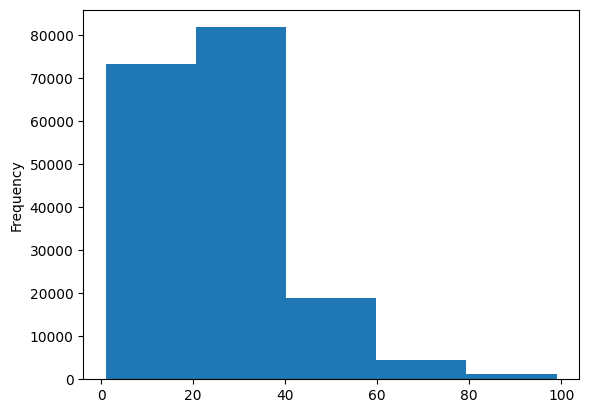

In [17]:
word_counts[word_counts < 100].plot.hist(bins = 5)

<Axes: ylabel='Frequency'>

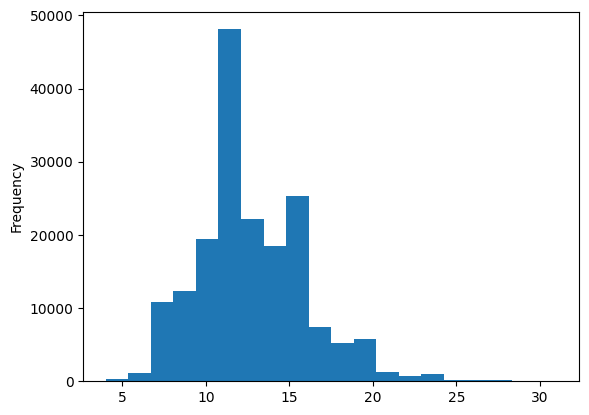

In [18]:
train_df.total_lines.plot.hist(bins = 20)

In [19]:
X_train = train_df['text'].to_list()
X_test = test_df['text'].to_list()
X_val = val_df['text'].to_list()

## Converting labels to numerical format

### One Hot

In [20]:
# Same results using sklearn
one_hot = OneHotEncoder(sparse_output=False)
train_one_hot = one_hot.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
test_one_hot = one_hot.transform(test_df['target'].to_numpy().reshape(-1,1))
val_one_hot = one_hot.transform(val_df['target'].to_numpy().reshape(-1,1))

In [21]:
train_one_hot, val_one_hot

(array([[0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]))

### Label Encoding

In [22]:
label_encoder = LabelEncoder()
train_label = label_encoder.fit_transform(train_df['target'].to_numpy())
test_label = label_encoder.transform(test_df['target'].to_numpy())
val_label = label_encoder.transform(val_df['target'].to_numpy())

In [23]:
train_label

array([3, 2, 2, ..., 4, 1, 1])

In [24]:
CLASS_NAMES  = label_encoder.classes_

In [25]:
CLASS_NAMES

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Creating Model Baseline

In [26]:
model_0 = Pipeline(
    steps=[
        ('vectorizer', TfidfVectorizer()),
        ( 'clf', MultinomialNB())
    ]
)

In [27]:
model_0.fit(X_train, train_label)

Pipeline(steps=[('vectorizer', TfidfVectorizer()), ('clf', MultinomialNB())])

In [28]:
baseline_preds = model_0.predict(X_val)

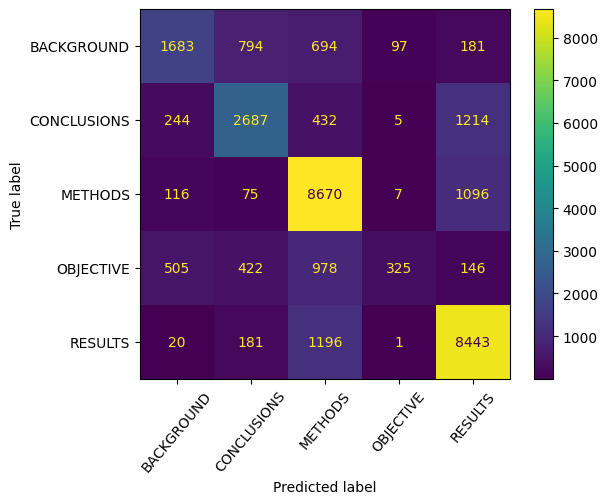

In [29]:
baseline_cm, baseline_report, baseline_metrics = get_cm_and_final_results(baseline_preds, val_label)

In [30]:
baseline_report

,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.655374,0.646069,0.724311,0.747126,0.762004,0.721832,0.706977,0.718647
recall,0.487968,0.586425,0.870132,0.136785,0.857941,0.721832,0.587850,0.721832
f1-score,0.559415,0.614804,0.790553,0.231234,0.807132,0.721832,0.600628,0.698925
support,3449.000000,4582.000000,9964.000000,2376.000000,9841.000000,0.721832,30212.000000,30212.000000


In [31]:
baseline_metrics

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [32]:
del model_0

# Model Version 1 - Simple CNN based

In [33]:
np.percentile(word_counts, 95)

55.0

In [34]:
VOCAB_SIZE = 68000
NUM_TOKENS = 55
vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=NUM_TOKENS,
)

I0000 00:00:1732792753.419011 1073995 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [35]:
# vectorizer.adapt(X_train)

In [38]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

In [39]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = model_1_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(NUM_CLASSES,activation = 'softmax')(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [40]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 55, 128)           256       
                                                                 
 conv1d (Conv1D)             (None, 49, 128)           114816    
                                                                 
 max_pooling1d (MaxPooling1  (None, 24, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 64)            24640 

## Processing data to tf Datasets to make faster calculations

In [50]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_train, train_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_test, test_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
val_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(X_val, val_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )


In [51]:
for line,label in train_dataset.take(1):
    print(np.concatenate((np.expand_dims(line.numpy(), axis=-1), label.numpy()),axis=-1)[:5])

[[b'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'
  0.0 0.0 0.0 1.0 0.0]
 [b'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'
  0.0 0.0 1.0 0.0 0.0]
 [b'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .'
  0.0 0.0 1.0 0.0 0.0]
 [b'pain was assessed using the visual analog pain scale ( @-@ mm ) .'
  0.0 0.0 1.0 0.0 0.0]
 [b'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'
  0.0 0.0 1.0 0.0 0.0]]


2024-11-28 16:50:37.360206: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Updating model to fit in with new procedure

In [52]:
#Enabling mixed float
keras.mixed_precision.set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4050 Laptop GPU, compute capability 8.9


In [53]:
EMBEDDING_DIMENSIONS = 128
model_1_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = vectorizer(inputs)
x = model_1_embedding(x)
x = keras.layers.Conv1D(128,7, activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.Conv1D(64,3,activation='relu')(x)
x = keras.layers.MaxPool1D(2)(x)
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_1 = keras.Model(inputs,outputs)

model_1.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [54]:
def plot_model(model):
    return keras.utils.plot_model(
    model=model, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

In [55]:
if True:
    keras.utils.plot_model(
    model=model_1, 
    show_dtype=True,
    show_layer_activations=True,
    expand_nested=True,
    show_shapes=True,
    show_trainable=True
                       )

In [56]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding_2 (Embedding)     (None, 55, 128)           256       
                                                                 
 conv1d_2 (Conv1D)           (None, 49, 128)           114816    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 24, 128)           0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 22, 64)            2464

In [57]:
# history_model_1 = model_1.fit(
#     train_dataset,
#     validation_data = val_dataset,
#     epochs=3,
#     initial_epoch=0,
#     batch_size=BATCH_SIZE,
#     callbacks=[create_tensorboard_callback('CNN', 'RUN2')],
#     steps_per_epoch = int(len(train_dataset)/10),
#     validation_steps = int(len(val_dataset)/10)
# )

In [58]:
# model_1_preds = np.argmax(model_1.predict(val_dataset), axis=-1)

In [59]:
# model_1_cm, model_1_report, model_1_metrics = get_cm_and_final_results(model_1_preds, val_label)

In [60]:
# model_1_report - baseline_report

In [ ]:
del model_1
del model_1_embedding

# Model Version 2 - Pretrained Embeddings

In [62]:
universal_sentence_encoder = hub.KerasLayer(
    handle="https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
    trainable=False,
    name='USE'
)

In [63]:
universal_sentence_encoder([' what joja', 'n'])

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.04555983, -0.00660281, -0.01276617, ..., -0.04721962,
         0.07622743,  0.01372085],
       [-0.02442588, -0.03740193, -0.01249437, ..., -0.07511895,
         0.04019829,  0.00873134]], dtype=float32)>

In [64]:
class USE(keras.layers.Layer):

    def __init__(self, encoder):

        super().__init__()
        self.encoder = encoder
    
    def call(self, inputs):
        return self.encoder(inputs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder,
        })

        return config

In [65]:
# model_2 = keras.Sequential([
#     keras.layers.Input(shape=[], dtype=tf.string),
#     USE(universal_sentence_encoder),
#     keras.layers.Dense(128, activation='relu'),
#     keras.layers.Dense(NUM_CLASSES),
#     keras.layers.Activation('softmax', dtype=tf.float32),
# ])

# model_2.compile(
#     optimizer= keras.optimizers.Adam(), 
#     loss = keras.losses.CategoricalCrossentropy(), 
#     metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
#     )

In [66]:
inputs = keras.layers.Input(shape=[], dtype=tf.string)

x = universal_sentence_encoder(inputs, training=False)
# x = keras.layers.Conv1D(128,7, activation='relu')(x)
# x = keras.layers.MaxPool1D(2)(x)
# x = keras.layers.Conv1D(64,3,activation='relu')(x)
# x = keras.layers.MaxPool1D(2)(x)
# x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_2 = keras.Model(inputs,outputs)

model_2.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [67]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
 activation_1 (Activation)   (None, 5)                 0         
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [68]:
# history_model_2 = model_2.fit(
#     train_dataset,
#     validation_data = val_dataset,
#     epochs=3,
#     initial_epoch=0,
#     batch_size=BATCH_SIZE,
#     #callbacks=[create_tensorboard_callback('USE', 'RUN1')],
#     steps_per_epoch = int(len(train_dataset)/10),
#     validation_steps = int(len(val_dataset)/10)
# )

In [69]:
# model_2_preds = np.argmax(model_2.predict(val_dataset), axis=-1)
# model_2_cm, model_2_report, model_2_metrics = get_cm_and_final_results(model_2_preds, val_label)

In [70]:
# model_2_report - baseline_report

In [71]:
del model_2
del universal_sentence_encoder

# Model Version 3 - Character Level Embeddings

In [72]:
X_train_chars = [" ".join(list(sentence)) for sentence in X_train]
X_val_chars = [" ".join(list(sentence)) for sentence in X_val]
X_test_chars = [" ".join(list(sentence)) for sentence in X_test]

In [73]:
random_i = np.random.randint(len(X_train))
X_train[random_i], X_train_chars[random_i]

('patients were randomized to pop or srf before undergoing the ponseti method .',
 'p a t i e n t s   w e r e   r a n d o m i z e d   t o   p o p   o r   s r f   b e f o r e   u n d e r g o i n g   t h e   p o n s e t i   m e t h o d   .')

<Axes: ylabel='Frequency'>

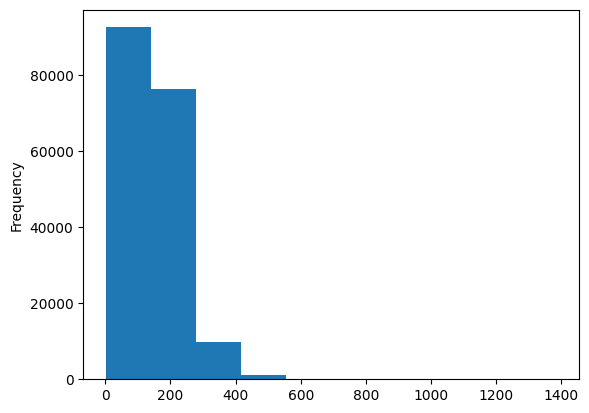

In [74]:
pd.Series(X_train).apply(len).plot.hist()

In [75]:
np.percentile(pd.Series(X_train).apply(len).to_numpy(), 95)

290.0

In [76]:
character_vectorizer = TextVectorization(
    max_tokens = 28,
    output_sequence_length=290,
    standardize="lower_and_strip_punctuation",
)

In [77]:
character_vectorizer.adapt(X_train_chars)

In [78]:
vocab = character_vectorizer.get_vocabulary()

In [79]:
EMBEDDING_DIMENSIONS = 25
model_3_embedding = Embedding(
    input_dim=28,
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

inputs = keras.layers.Input(shape=(1,), dtype=tf.string)

x = character_vectorizer(inputs)
x = model_3_embedding(x)
x = keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = keras.layers.GlobalMaxPooling1D()(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32)(x)

model_3 = keras.Model(inputs,outputs)

model_3.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [80]:
model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 290)               0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_4 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_6 (Dense)             (None, 5)                 325 

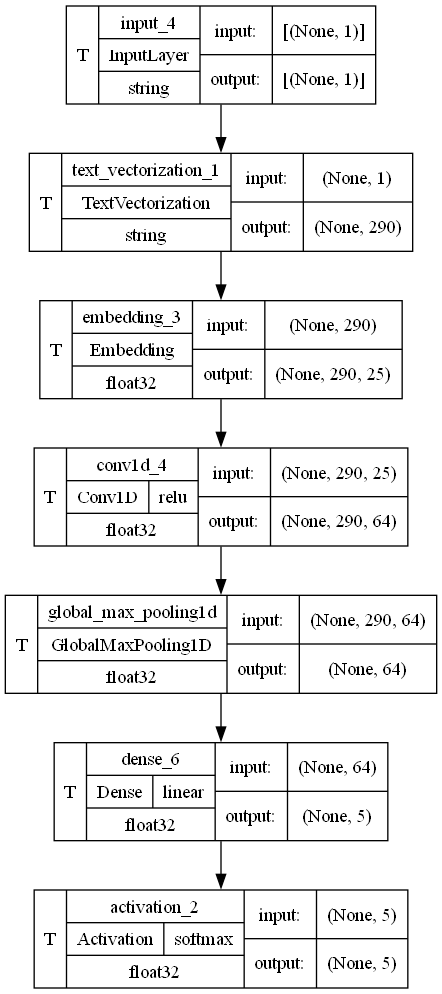

In [81]:
plot_model(model_3)

In [82]:
train_dataset_chars = tf.data.Dataset.from_tensor_slices(
    tensors=(X_train_chars, train_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
test_dataset_chars = tf.data.Dataset.from_tensor_slices(
    tensors=(X_test_chars, test_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
val_dataset_chars = tf.data.Dataset.from_tensor_slices(
    tensors=(X_val_chars, val_one_hot)
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )


In [83]:
# history_model_3 = model_3.fit(
#     train_dataset_chars,
#     validation_data=(val_dataset_chars),
#     epochs=3,
#     initial_epoch=0,
#     batch_size=BATCH_SIZE,
#     callbacks=[create_tensorboard_callback('CHARS', 'RUN1')],
#     steps_per_epoch = int(len(train_dataset)/10),
#     validation_steps = int(len(val_dataset)/10)
# )

In [84]:
# model_3_preds = np.argmax(model_3.predict(val_dataset_chars), axis=-1)
# model_3_cm, model_3_report, model_3_metrics = get_cm_and_final_results(model_3_preds, val_label)

In [85]:
# model_3_report - baseline_report

# Model Version 4 - Pretrained token embeddings + character embeddings

In [86]:
universal_sentence_encoder = hub.KerasLayer(
    handle="https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
    trainable=False,
    name='USE'
)

In [87]:
input_character = keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
x1 = character_vectorizer(input_character)
x1 = keras.layers.Embedding(input_dim=28,
    output_dim=32,
    mask_zero=False,)(x1)
x1 = keras.layers.Bidirectional(keras.layers.LSTM(32))(x1)

input_tokens = keras.layers.Input(shape=[], dtype=tf.string, name='word_input')
x2 = universal_sentence_encoder(input_tokens, training=False)
x2 = keras.layers.Dense(64, activation='relu')(x2)

x = keras.layers.Concatenate(-1)([x1,x2])
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32, name='outputs')(x)

model_4 = keras.Model(
    inputs = {
            'char_input' : input_character,
            'word_input' : input_tokens
        },
    outputs= {
        'outputs' : outputs
        }
    )

model_4.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [88]:
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 word_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 290, 32)              896       ['text_vectorization_1[1

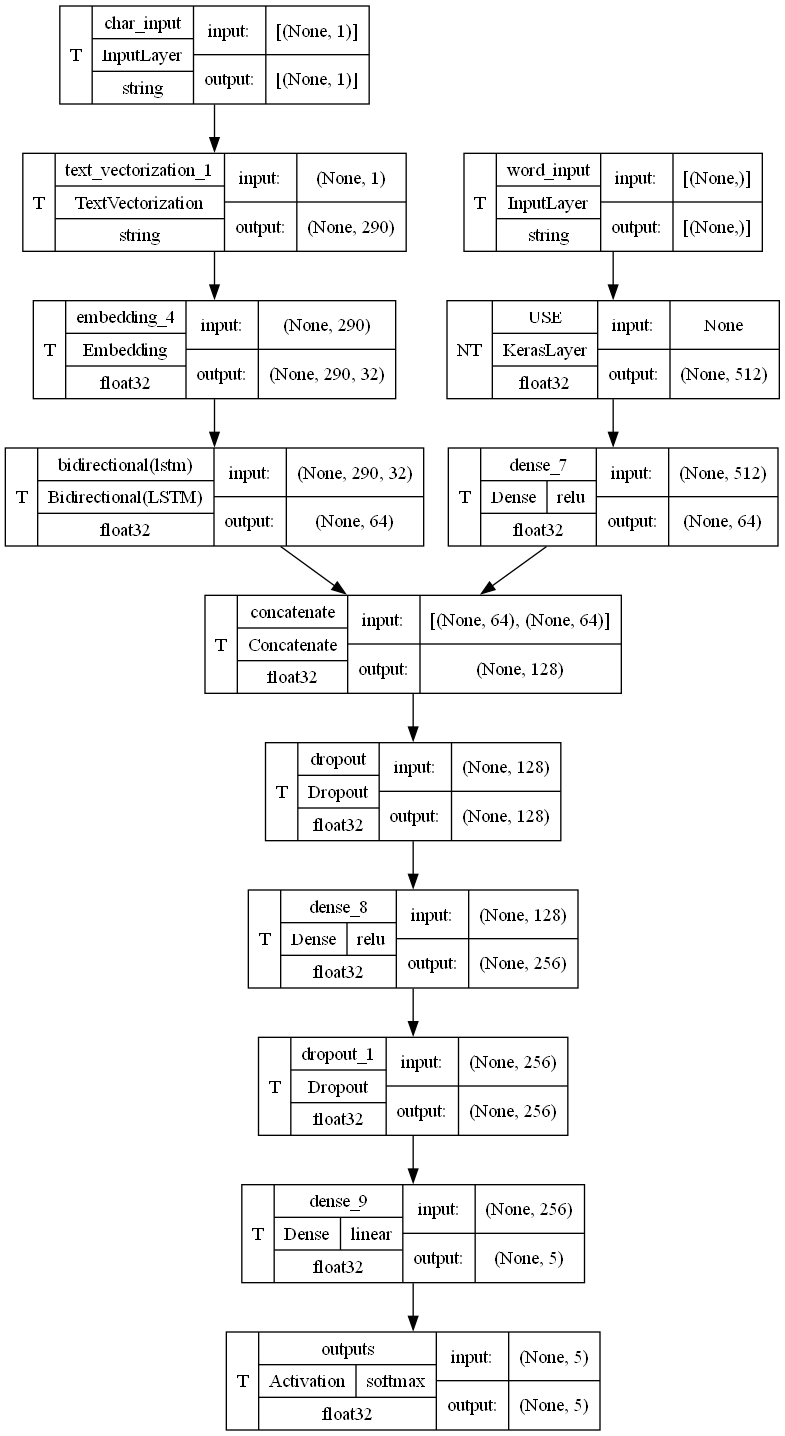

In [89]:
plot_model(model_4)

In [90]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(
        {
            'char_input' : X_train_chars,
            'word_input' : X_train
        },
        {
            'outputs' : train_one_hot
        }
    )
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(
        {
            'char_input' : X_test_chars,
            'word_input' : X_test
        },
        {
            'outputs' : test_one_hot
        }
    )
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
val_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(
        {
            'char_input' : X_val_chars,
            'word_input' : X_val
        },
        {
            'outputs' : val_one_hot
        }
    )
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )

In [91]:
train_dataset.element_spec

({'char_input': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'word_input': TensorSpec(shape=(None,), dtype=tf.string, name=None)},
 {'outputs': TensorSpec(shape=(None, 5), dtype=tf.float64, name=None)})

In [92]:
# history_model_4 = model_4.fit(
#     train_dataset,
#     validation_data=(val_dataset),
#     epochs=3,
#     initial_epoch=0,
#     batch_size=BATCH_SIZE,
#     callbacks=[create_tensorboard_callback('HYBRID', 'RUN1')],
#     steps_per_epoch = int(len(train_dataset)/10),
#     validation_steps = int(len(val_dataset)/10)
# )

In [93]:
# p = model_4.predict(val_dataset)
# model_4_preds = np.argmax(p['outputs'], axis=-1)


In [94]:
# model_4_preds

In [95]:
# model_4_cm, model_4_report, model_4_metrics = get_cm_and_final_results(model_4_preds, val_label)
# model_4_report - baseline_report

In [96]:
# MODELS_REPORT = pd.DataFrame(data={
#    'baseline' : baseline_metrics, 
#    'CNN' : model_1_metrics ,
#    'USE' : model_2_metrics ,
#    'CHAR' : model_3_metrics, 
# }
# ).T

In [97]:
# MODELS_REPORT[['precision','recall','f1']].plot.bar()

In [98]:
# MODELS_REPORT = MODELS_REPORT.T
# MODELS_REPORT['HYBRID']  = model_4_metrics
# MODELS_REPORT = MODELS_REPORT.T

In [99]:
# MODELS_REPORT[['precision','recall','f1']].plot.bar()
# plt.legend(loc=(0,1))
# plt.figure()
# plt.title('Accuracy')
# MODELS_REPORT['accuracy'].plot.bar(color='r')


In [100]:
# MODELS_REPORT.to_csv(MAIN_DIR.joinpath('metrics.csv'))

In [137]:
def update_report(name :str, metrics :dict):
    MODELS_REPORT = pd.read_csv(MAIN_DIR.joinpath('metrics.csv'), index_col='name')
    MODELS_REPORT = MODELS_REPORT.T
    MODELS_REPORT[name]  = metrics
    MODELS_REPORT = MODELS_REPORT.T
    MODELS_REPORT.to_csv(MAIN_DIR.joinpath('metrics.csv'))
    return MODELS_REPORT

In [102]:
MODELS_REPORT = pd.read_csv(MAIN_DIR.joinpath('metrics.csv'))

# Model Version 5 - Adding Transition probabilities

<Axes: ylabel='Frequency'>

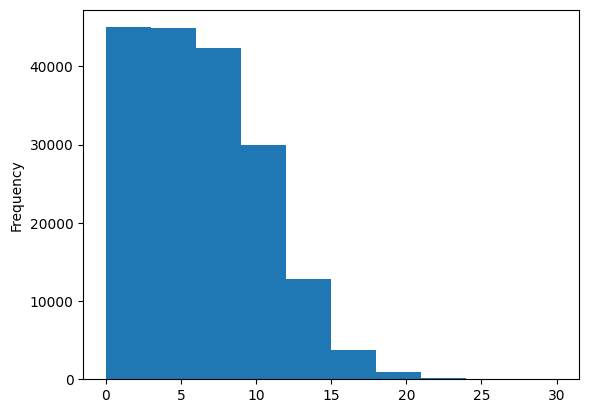

In [103]:
line_numbers = train_df['line_number']
line_numbers.plot(kind='hist')

In [104]:
np.percentile(line_numbers,99.8)

20.0

In [105]:
line_one_hot_train = tf.one_hot(train_df['line_number'].to_numpy(), depth=15)
line_one_hot_test = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)
line_one_hot_val = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)

<Axes: ylabel='Frequency'>

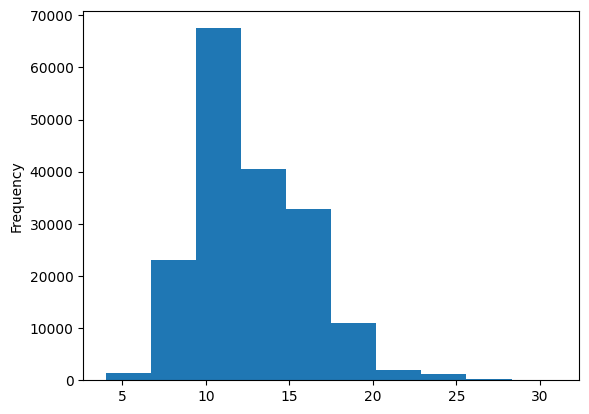

In [106]:
total_lines=train_df['total_lines']
total_lines.plot(kind='hist')

In [107]:
np.percentile(total_lines,99.8)

26.0

In [108]:
total_one_hot_train = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
total_one_hot_test = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
total_one_hot_val = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)

In [109]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(
        {
            'char_input' : X_train_chars,
            'word_input' : X_train,
            'line_number' : line_one_hot_train,
            'total_lines' : total_one_hot_train
        },
        {
            'outputs' : train_one_hot
        }
    )
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
test_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(
        {
            'char_input' : X_test_chars,
            'word_input' : X_test,
            'line_number' : line_one_hot_test,
            'total_lines' : total_one_hot_test
        },
        {
            'outputs' : test_one_hot
        }
    )
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )
val_dataset = tf.data.Dataset.from_tensor_slices(
    tensors=(
        {
            'char_input' : X_val_chars,
            'word_input' : X_val,
            'line_number' : line_one_hot_val,
            'total_lines' : total_one_hot_val
        },
        {
            'outputs' : val_one_hot
        }
    )
    ).batch(
            batch_size=BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE
            ).prefetch(
                buffer_size=tf.data.AUTOTUNE
                )

In [110]:
train_dataset.element_spec

({'char_input': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'word_input': TensorSpec(shape=(None,), dtype=tf.string, name=None),
  'line_number': TensorSpec(shape=(None, 15), dtype=tf.float32, name=None),
  'total_lines': TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)},
 {'outputs': TensorSpec(shape=(None, 5), dtype=tf.float64, name=None)})

In [111]:
input_character = keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
x1 = character_vectorizer(input_character)
x1 = keras.layers.Embedding(input_dim=28,
    output_dim=32,
    mask_zero=False,)(x1)
x1 = keras.layers.Bidirectional(keras.layers.LSTM(32))(x1)

input_tokens = keras.layers.Input(shape=[], dtype=tf.string, name='word_input')
x2 = universal_sentence_encoder(input_tokens, training=False)
x2 = keras.layers.Dense(128, activation='relu')(x2)

input_lines = keras.layers.Input(shape=(15,), name='line_number')
x3 = keras.layers.Dense(32, activation='relu')(input_lines)

input_total = keras.layers.Input(shape=(20,), name='total_lines')
x4 = keras.layers.Dense(32, activation='relu')(input_total)

x5 = keras.layers.Concatenate(-1)([x1,x2])
x5 = keras.layers.Dense(256, activation='relu')(x5)
x5 = keras.layers.Dropout(0.5)(x5)

x = keras.layers.Concatenate(axis=-1)([x3,x4,x5])

x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32, name='outputs')(x)

model_5 = keras.Model(
    inputs = {
            'char_input' : input_character,
            'word_input' : input_tokens,
            'line_number' : input_lines,
            'total_lines' : input_total,
        },
    outputs= {
        'outputs' : outputs
        }
    )

model_5.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [112]:
model_5.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_1 (Text  (None, 290)                  0         ['char_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 word_input (InputLayer)     [(None,)]                    0         []                            
                                                                                                  
 embedding_5 (Embedding)     (None, 290, 32)              896       ['text_vectorization_1[2

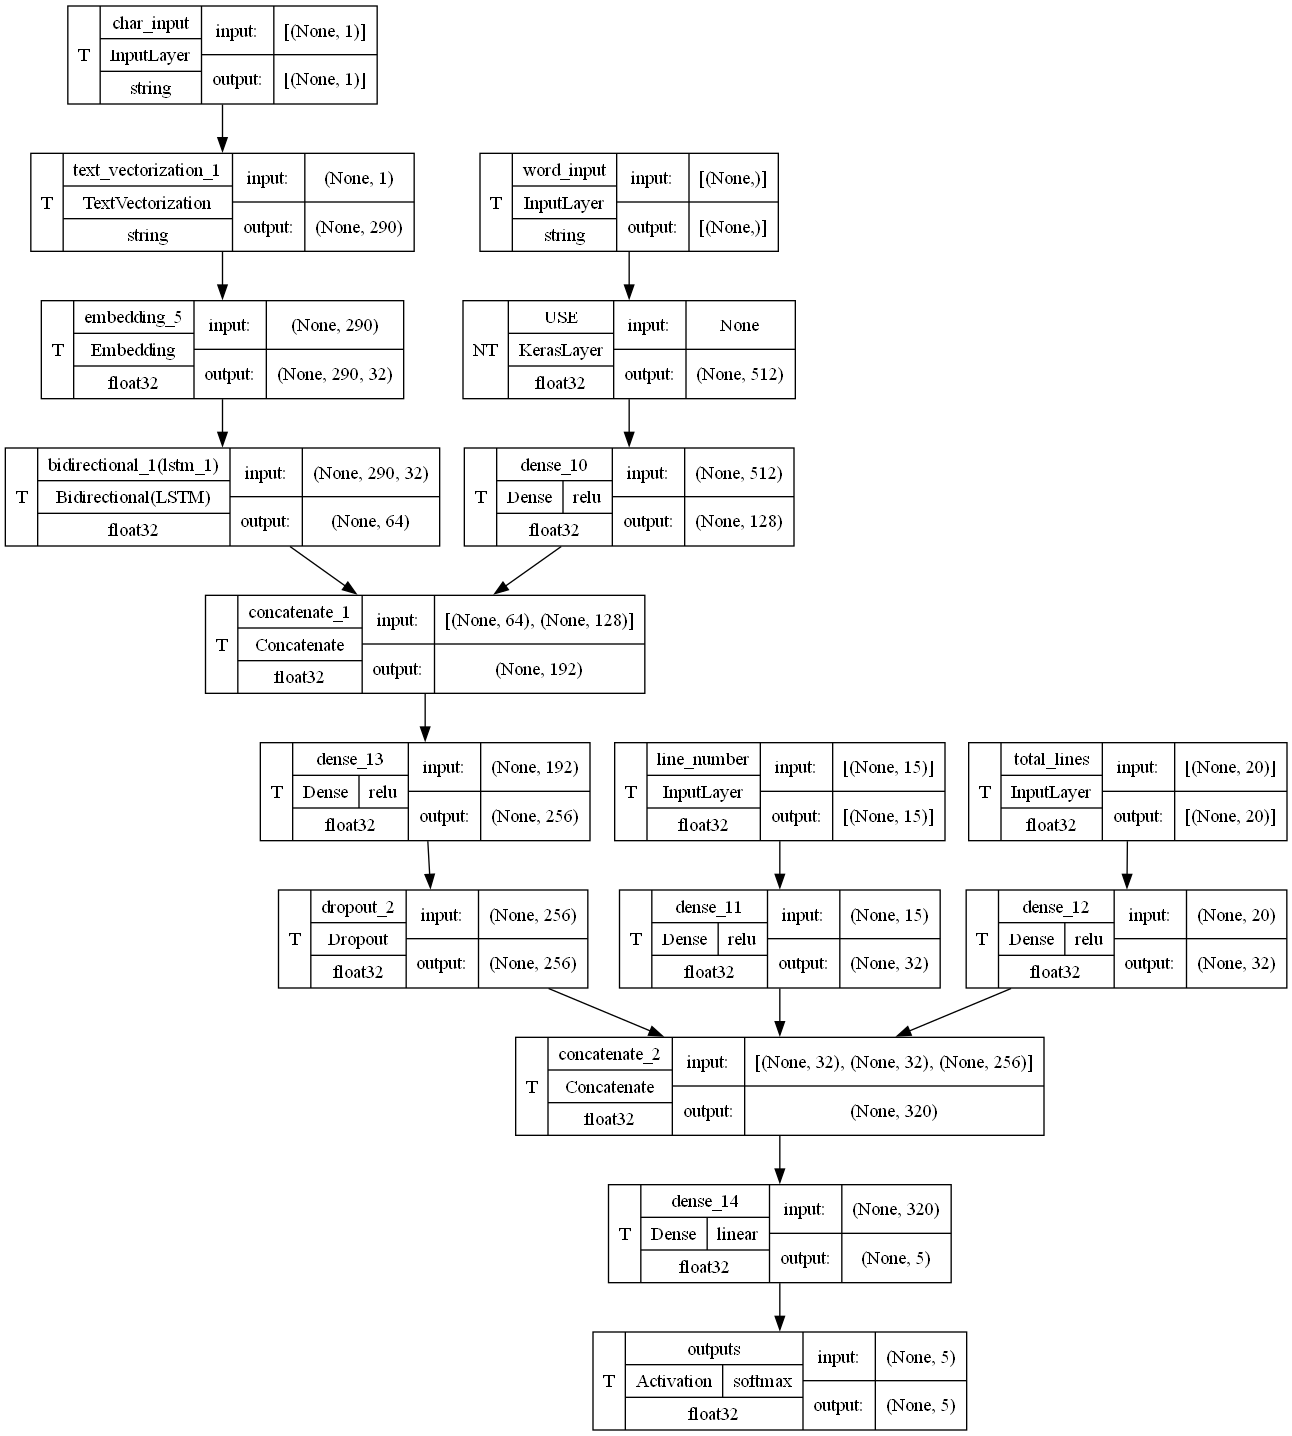

In [113]:
plot_model(model_5)

## Running experiment 1

In [114]:
history_model_5 = model_5.fit(
    train_dataset,
    validation_data=(val_dataset),
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    callbacks=[create_tensorboard_callback('TRIBRID', 'RUN1')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/experiments/TRIBRID/RUN1
Epoch 1/3


2024-11-28 16:52:40.904117: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1732792961.457914 1074165 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1732792962.642966 1074172 service.cc:148] XLA service 0x7f845c086100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732792962.644654 1074172 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-28 16:52:42.841954: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732792963.383627 1074175 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 [==============================] - 61s 84ms/step - loss: 0.7707 - accuracy: 0.7100 - val_loss: 0.5517 - val_accuracy: 0.7992
Epoch 2/3
562/562 [==============================] - 44s 78ms/step - loss: 0.5071 - accuracy: 0.8079 - val_loss: 0.4721 - val_accuracy: 0.8231
Epoch 3/3
562/562 [==============================] - 43s 76ms/step - loss: 0.4683 - accuracy: 0.8162 - val_loss: 0.4487 - val_accuracy: 0.8238


In [115]:
p = model_5.predict(val_dataset)
model_5_preds = np.argmax(p['outputs'], axis=-1)

945/945 [==============================] - 37s 38ms/step


,BACKGROUND,CONCLUSIONS,METHODS,OBJECTIVE,RESULTS,accuracy,macro avg,weighted avg
precision,0.035707,0.169137,0.163482,-0.065634,0.089767,0.10423,0.078492,0.107723
recall,0.253407,0.256002,-0.011742,0.462963,0.012092,0.10423,0.194544,0.104230
f1-score,0.155930,0.213789,0.082291,0.406778,0.053674,0.10423,0.182492,0.126838
support,0.000000,0.000000,0.000000,0.000000,0.000000,0.10423,0.000000,0.000000


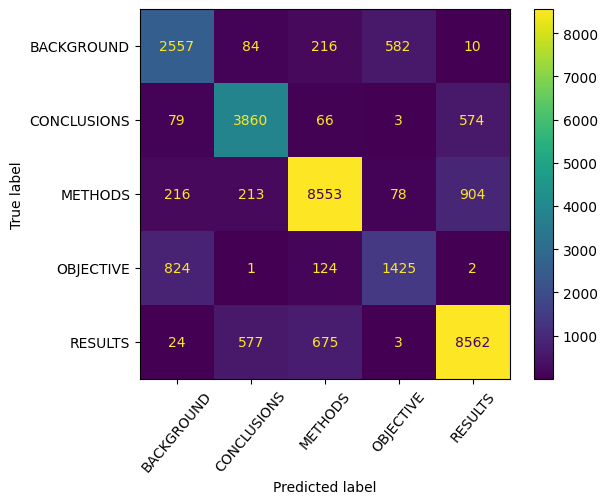

In [116]:
model_5_cm, model_5_report, model_5_metrics = get_cm_and_final_results(model_5_preds, val_label)
model_5_report - baseline_report

In [117]:
MODELS_REPORT = update_report('TriBrid', model_5_metrics)

<Axes: title={'center': 'Accuracy'}>

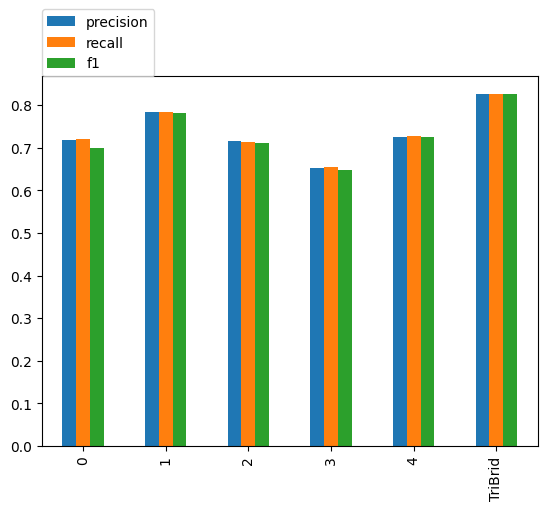

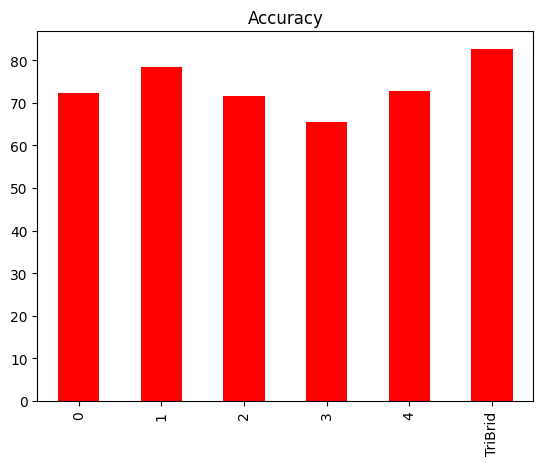

In [118]:
MODELS_REPORT[['precision','recall','f1']].plot.bar()
plt.legend(loc=(0,1))
plt.figure()
plt.title('Accuracy')
MODELS_REPORT['accuracy'].plot.bar(color='r')

## Experiment 2 

Using token embedding instead of USE

In [126]:
EMBEDDING_DIMENSIONS = 128
VOCAB_SIZE = 68000
NUM_TOKENS = 55


vectorizer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=NUM_TOKENS,
)

In [127]:
vectorizer.adapt(X_train)

In [128]:
token_embedding = Embedding(
    input_dim=len(vectorizer.get_vocabulary()),
    output_dim=EMBEDDING_DIMENSIONS,
    mask_zero=True,
)

In [134]:
input_character = keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
x1 = character_vectorizer(input_character)
x1 = keras.layers.Embedding(input_dim=28,
    output_dim=32,
    mask_zero=False,)(x1)
x1 = keras.layers.Bidirectional(keras.layers.LSTM(32))(x1)

input_tokens = keras.layers.Input(shape=(1,), dtype=tf.string, name='word_input')
x2 = vectorizer(input_tokens)
x2 = token_embedding(x2)
x2 = keras.layers.Conv1D(128,7, activation='relu')(x2)
x2 = keras.layers.MaxPool1D(2)(x2)
x2 = keras.layers.Conv1D(64,3,activation='relu')(x2)
x2 = keras.layers.MaxPool1D(2)(x2)
x2 = keras.layers.GlobalAveragePooling1D()(x2)
x2 = keras.layers.Dense(128, activation='relu')(x2)

input_lines = keras.layers.Input(shape=(15,), name='line_number')
x3 = keras.layers.Dense(32, activation='relu')(input_lines)

input_total = keras.layers.Input(shape=(20,), name='total_lines')
x4 = keras.layers.Dense(32, activation='relu')(input_total)

x5 = keras.layers.Concatenate(-1)([x1,x2])
x5 = keras.layers.Dense(256, activation='relu')(x5)
x5 = keras.layers.Dropout(0.5)(x5)

x = keras.layers.Concatenate(axis=-1)([x3,x4,x5])

x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32, name='outputs')(x)

model_6 = keras.Model(
    inputs = {
            'char_input' : input_character,
            'word_input' : input_tokens,
            'line_number' : input_lines,
            'total_lines' : input_total,
        },
    outputs= {
        'outputs' : outputs
        }
    )

model_6.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(label_smoothing=0.2), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [135]:
model_6.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 word_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 text_vectorization_2 (Text  (None, 55)                   0         ['word_input[0][0]']          
 Vectorization)                                                                                   
                                                                                                  
 embedding_6 (Embedding)     (None, 55, 128)              8299648   ['text_vectorization_2[2][0]']
                                                                                                  
 conv1d_9 (Conv1D)           (None, 49, 128)              114816    ['embedding_6[2][0]']   

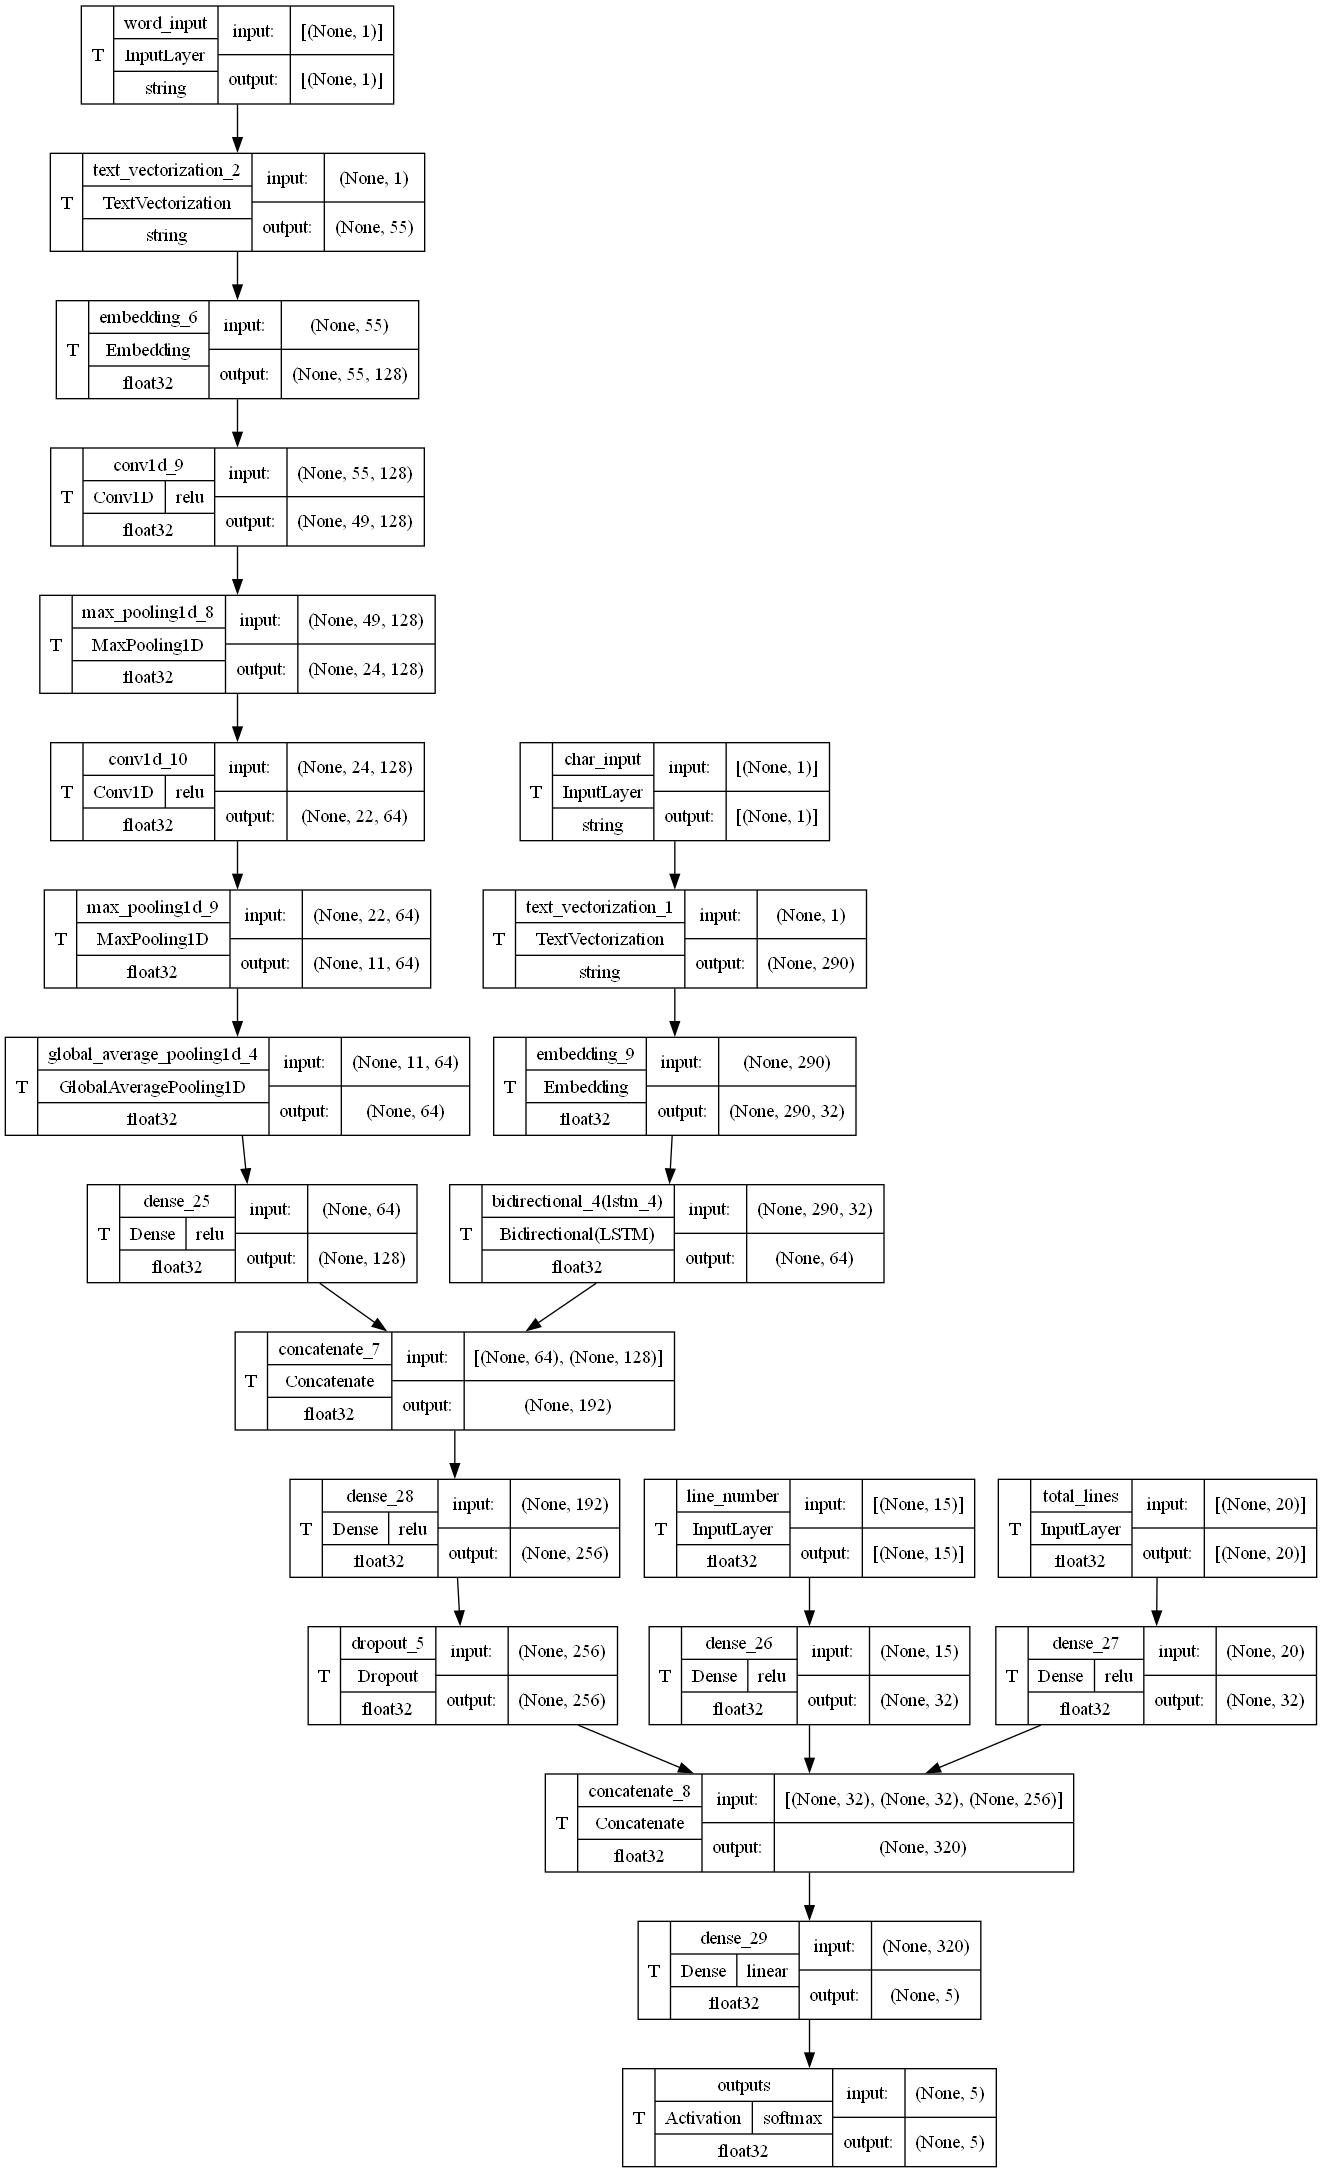

In [136]:
plot_model(model_6)

In [138]:
history_model_6 = model_6.fit(
    train_dataset,
    validation_data=(val_dataset),
    epochs=3,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    callbacks=[create_tensorboard_callback('TriBrid_Custom_Embeds', 'RUN1')],
    steps_per_epoch = int(len(train_dataset)/10),
    validation_steps = int(len(val_dataset)/10)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/experiments/TriBrid_Custom_Embeds/RUN1
Epoch 1/3
562/562 [==============================] - 87s 131ms/step - loss: 1.1208 - accuracy: 0.6978 - val_loss: 0.9549 - val_accuracy: 0.8118
Epoch 2/3
562/562 [==============================] - 47s 83ms/step - loss: 0.9490 - accuracy: 0.8273 - val_loss: 0.9212 - val_accuracy: 0.8368
Epoch 3/3
562/562 [==============================] - 36s 65ms/step - loss: 0.9247 - accuracy: 0.8397 - val_loss: 0.9043 - val_accuracy: 0.8487


945/945 [==============================] - 22s 23ms/step


<Axes: title={'center': 'Accuracy'}, xlabel='name'>

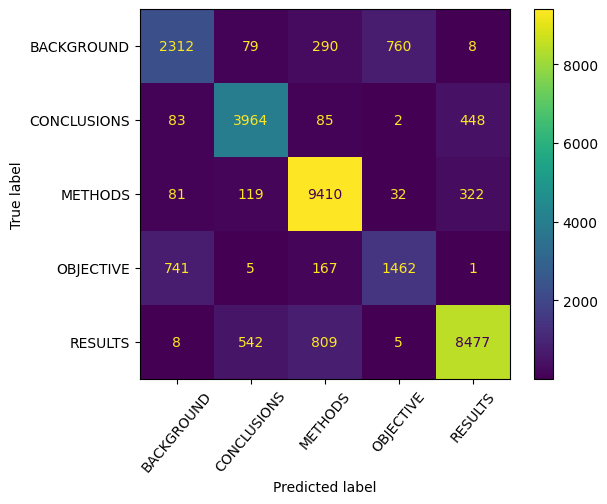

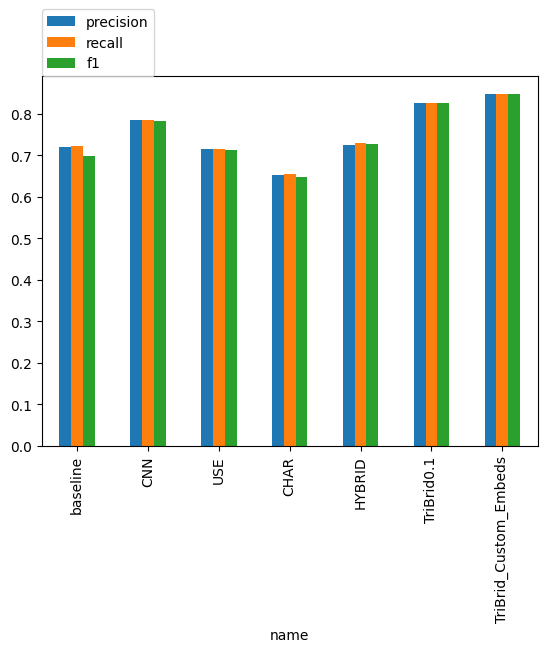

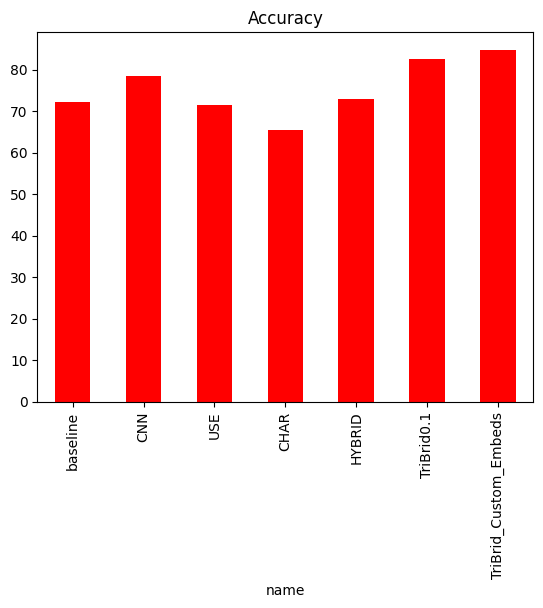

In [139]:
p = model_6.predict(val_dataset)
model_6_preds = np.argmax(p['outputs'], axis=-1)
model_6_cm, model_6_report, model_6_metrics = get_cm_and_final_results(model_6_preds, val_label)
model_6_report - baseline_report
MODELS_REPORT = update_report('TriBrid_Custom_Embeds', model_6_metrics)
MODELS_REPORT[['precision','recall','f1']].plot.bar()
plt.legend(loc=(0,1))
plt.figure()
plt.title('Accuracy')
MODELS_REPORT['accuracy'].plot.bar(color='r')

(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f8703fdecf0>,
 <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x7f85404b9520>)

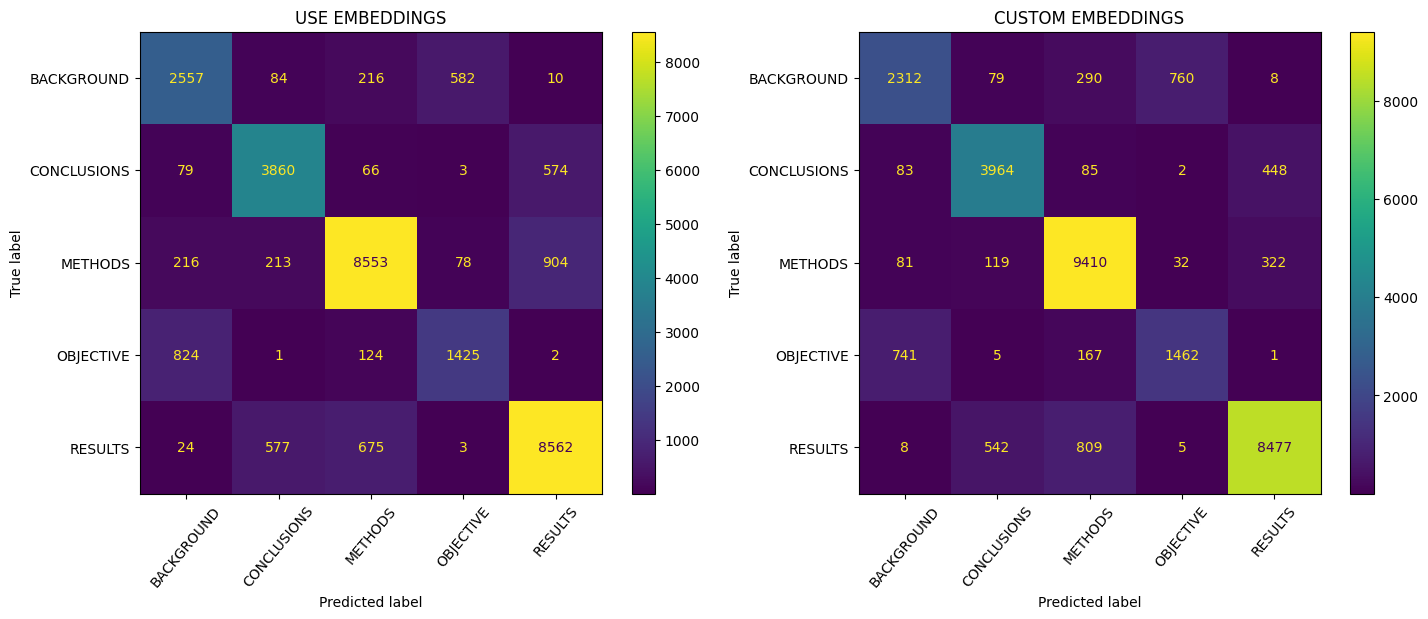

In [152]:
fig, axx = plt.subplots(1,2,figsize=(17,6))
axx[0].set_title('USE EMBEDDINGS')
axx[1].set_title('CUSTOM EMBEDDINGS')
model_5_cm.plot(xticks_rotation=50, ax=axx[0]),model_6_cm.plot(xticks_rotation=50,ax=axx[1])

# Try to recreate the transition matrix procedure along with model 6

In [217]:
np.set_printoptions(linewidth=200)

In [ ]:
CLASS_NAMES.sort()

In [ ]:
transition_matrix = np.zeros(shape=(NUM_CLASSES,NUM_CLASSES))
for row in train_df.itertuples():
    _,target,_,ln,tl,_ = row
    target =  np.squeeze(np.where(CLASS_NAMES == target))
    if ln == 0:
        before = target
    else:
        transition_matrix[before, target] += 1
        before = target


In [203]:
transition_matrix

array([[1.1363e+04, 4.0000e+00, 5.4920e+03, 1.8330e+03, 3.4300e+02],
       [2.6300e+03, 1.2345e+04, 2.0200e+02, 1.1000e+01, 7.0000e+00],
       [1.0500e+02, 8.5700e+02, 4.4551e+04, 5.9000e+01, 1.3553e+04],
       [2.3300e+02, 7.0000e+00, 9.0050e+03, 4.4150e+03, 1.7800e+02],
       [9.0000e+00, 1.3942e+04, 2.4000e+01, 0.0000e+00, 4.3872e+04]])

In [252]:
transition_probabilities = transition_matrix/np.expand_dims(np.sum(transition_matrix,axis=-1),axis=-1)

In [322]:
test = p['outputs'].copy()

In [325]:
test

array([[0.41653088, 0.06044808, 0.04498705, 0.44687238, 0.03116162],
       [0.6674694 , 0.14957406, 0.520186  , 0.58509016, 0.07768034],
       [0.6702599 , 0.25281394, 1.0851082 , 0.7586796 , 0.23313837],
       ...,
       [0.04560094, 0.14871877, 0.05744829, 0.0390808 , 0.7091512 ],
       [0.06304649, 0.75578654, 0.04102513, 0.03346739, 0.10667445],
       [0.07343747, 0.81877655, 0.02419937, 0.03766419, 0.04592234]], dtype=float32)

In [359]:
def add_matrix(weight=0,p=p):
    TRANSITION_WEIGHT = weight
    test = p['outputs'].copy()
    for k,(prob, line) in enumerate(zip(test,train_df['line_number'])):
        if line==0:
            last_probs = prob
        else:
            for i in range(NUM_CLASSES):
                for j in range(NUM_CLASSES):
                    prob[i] += transition_probabilities[j,i] * last_probs[j] * TRANSITION_WEIGHT
            last_probs = prob
    probs = tf.constant(np.array(test))
    new_output = keras.activations.softmax(probs)
    return new_output.numpy()

### Experimenting 

Goal choose the best weight to add the transition probabilities

<Axes: title={'center': 'Tranistion weight=0.9'}, xlabel='name'>

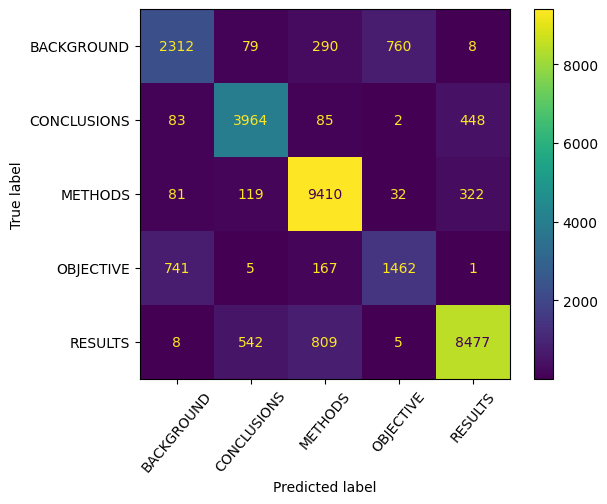

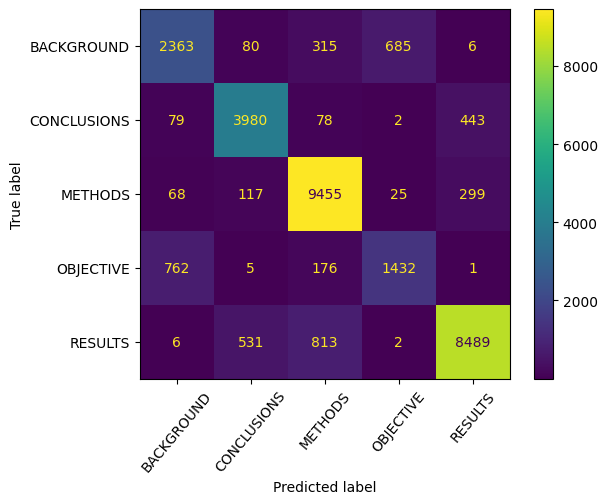

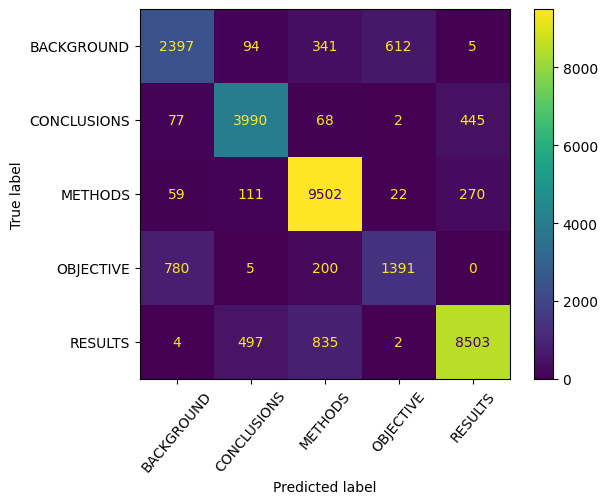

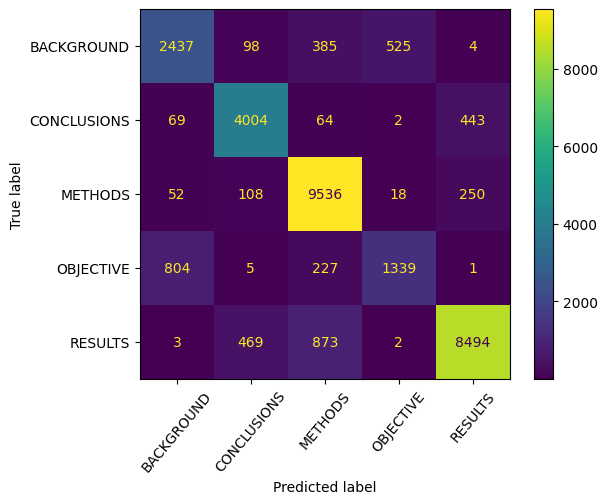

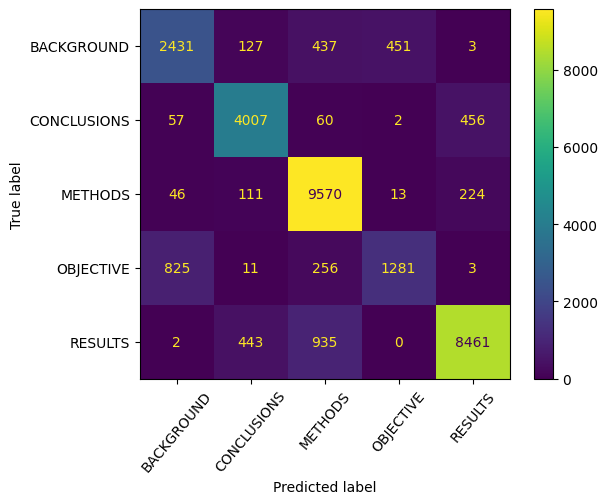

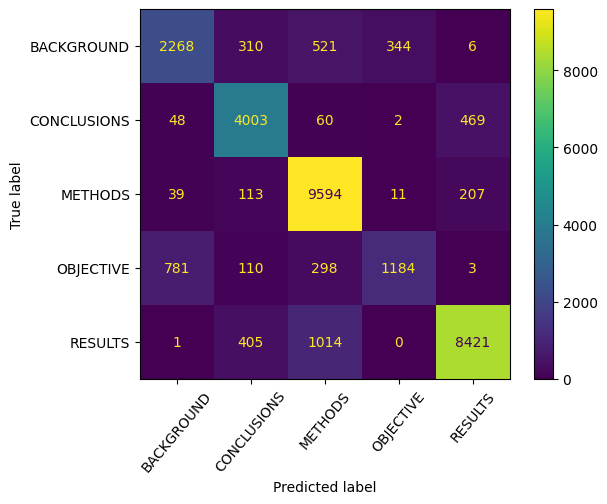

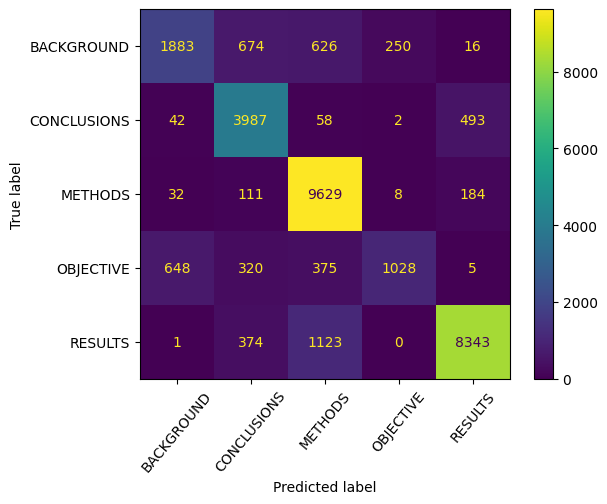

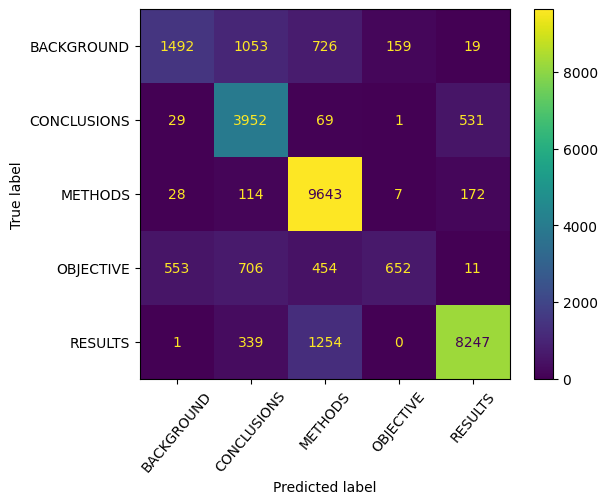

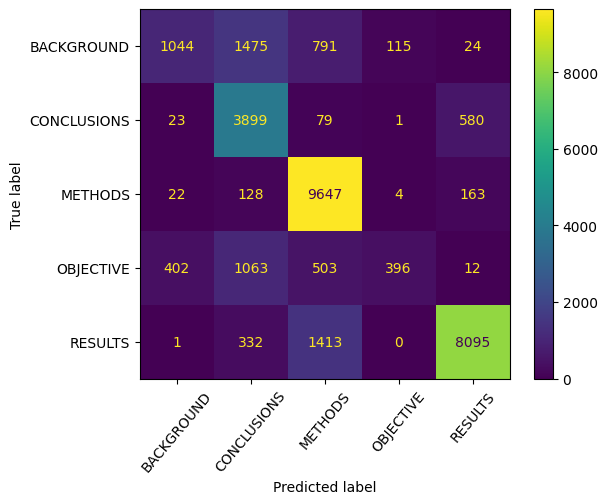

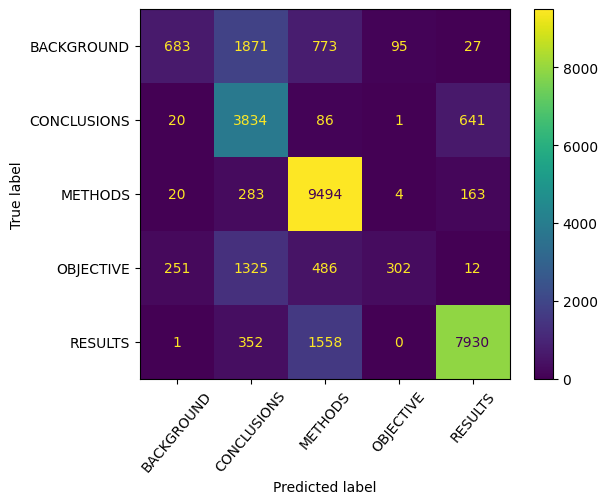

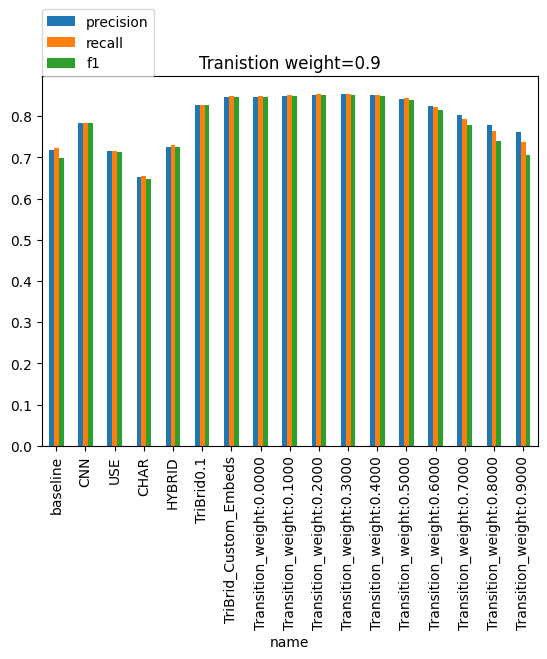

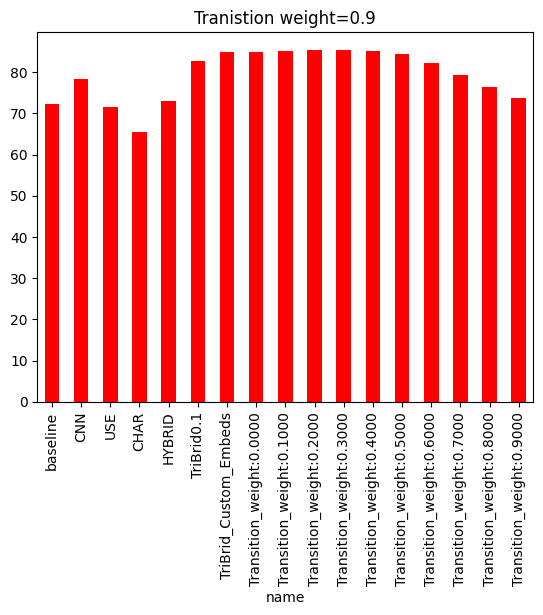

In [374]:
for weight in range(10):
    new = add_matrix(weight=0.1*weight)
    preds = np.argmax(new, axis=-1)
    _, _, metrics = get_cm_and_final_results(preds, val_label)
    MODELS_REPORT = update_report(f'Transition_weight:{0.1*weight:.4f}', metrics)

MODELS_REPORT[['precision','recall','f1']].plot.bar()
plt.title(f'Tranistion weight={0.1*weight}')
plt.legend(loc=(0,1))
plt.figure()
plt.title(f'Tranistion weight={0.1*weight}')
MODELS_REPORT['accuracy'].plot.bar(color='r')

a weight of 0.3 seems to perform best 

In [375]:
MODELS_REPORT.sort_values(by='accuracy', ascending=False)

,accuracy,precision,recall,f1
name,,,,
Transition_weight:0.3000,85.429631,0.852869,0.854296,0.851704
Transition_weight:0.2000,85.340262,0.851843,0.853403,0.851294
Transition_weight:0.4000,85.231034,0.851220,0.852310,0.849068
Transition_weight:0.1000,85.128426,0.849913,0.851284,0.849573
TriBrid_Custom_Embeds,84.817291,0.847076,0.848173,0.846765
Transition_weight:0.0000,84.817291,0.847076,0.848173,0.846765
Transition_weight:0.5000,84.304250,0.842512,0.843042,0.838225
TriBrid0.1,82.606249,0.826370,0.826062,0.825763
Transition_weight:0.6000,82.318284,0.825339,0.823183,0.815020


## Running experiment with whole dataset

In [379]:
input_character = keras.layers.Input(shape=(1,), dtype=tf.string, name='char_input')
x1 = character_vectorizer(input_character)
x1 = keras.layers.Embedding(input_dim=28,
    output_dim=32,
    mask_zero=False,)(x1)
x1 = keras.layers.Bidirectional(keras.layers.LSTM(32))(x1)

input_tokens = keras.layers.Input(shape=[], dtype=tf.string, name='word_input')
x2 = universal_sentence_encoder(input_tokens, training=False)
x2 = keras.layers.Dense(128, activation='relu')(x2)

input_lines = keras.layers.Input(shape=(15,), name='line_number')
x3 = keras.layers.Dense(32, activation='relu')(input_lines)

input_total = keras.layers.Input(shape=(20,), name='total_lines')
x4 = keras.layers.Dense(32, activation='relu')(input_total)

x5 = keras.layers.Concatenate(-1)([x1,x2])
x5 = keras.layers.Dense(256, activation='relu')(x5)
x5 = keras.layers.Dropout(0.5)(x5)

x = keras.layers.Concatenate(axis=-1)([x3,x4,x5])

x = keras.layers.Dense(NUM_CLASSES)(x)
outputs = keras.layers.Activation(keras.activations.softmax, dtype=tf.float32, name='outputs')(x)

model_7 = keras.Model(
    inputs = {
            'char_input' : input_character,
            'word_input' : input_tokens,
            'line_number' : input_lines,
            'total_lines' : input_total,
        },
    outputs= {
        'outputs' : outputs
        }
    )

In [380]:
model_7.compile(
    optimizer= keras.optimizers.Adam(), 
    loss = CategoricalCrossentropy(label_smoothing=0.2), 
    metrics=['accuracy']#, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.F1Score()]
    )

In [381]:
model_7.evaluate(val_dataset)

945/945 [==============================] - 47s 44ms/step - loss: 1.6167 - accuracy: 0.1988


[1.6167165040969849, 0.19879518449306488]

Model is clealy guessing

In [382]:
history_model_7 = model_7.fit(
    train_dataset,
    validation_data=(val_dataset),
    epochs=10,
    initial_epoch=0,
    batch_size=BATCH_SIZE,
    callbacks=[create_tensorboard_callback('Final', 'RUN1'),create_model_checkpoint_callback('Final')],
    # steps_per_epoch = int(len(train_dataset)/10),
    # validation_steps = int(len(val_dataset)/10)
)

Saving log files to : /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/experiments/Final/RUN1
Epoch 1/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9539 - accuracy: 0.8224
Epoch 1: val_accuracy improved from -inf to 0.84979, saving model to /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/checkpoints/Final.weights.h5
5627/5627 [==============================] - 430s 75ms/step - loss: 0.9539 - accuracy: 0.8224 - val_loss: 0.9078 - val_accuracy: 0.8498
Epoch 2/10
5627/5627 [==============================] - ETA: 0s - loss: 0.9098 - accuracy: 0.8542
Epoch 2: val_accuracy improved from 0.84979 to 0.85370, saving model to /home/yehand/.vscode-server/projects/NLP_Learning/JSCReplication/checkpoints/Final.weights.h5
5627/5627 [==============================] - 406s 72ms/step - loss: 0.9098 - accuracy: 0.8542 - val_loss: 0.9003 - val_accuracy: 0.8537
Epoch 3/10
5627/5627 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.

testing on the test dataset

In [383]:
p = model_7.predict(test_dataset)

942/942 [==============================] - 41s 40ms/step


<Axes: title={'center': 'Tranistion weight=0.9'}, xlabel='name'>

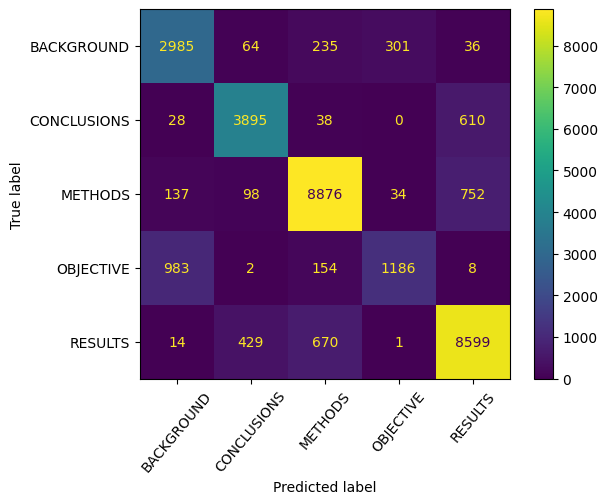

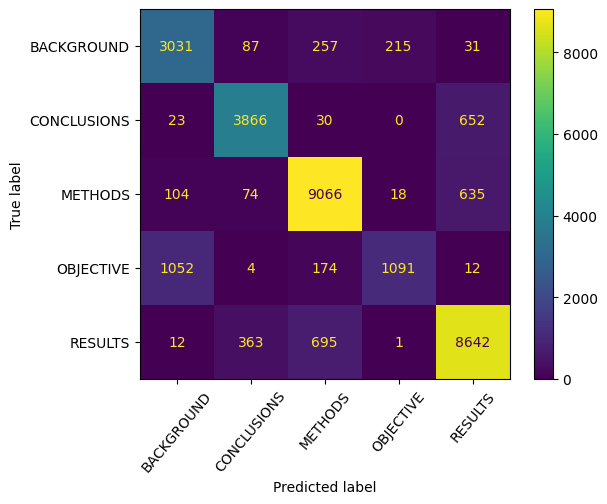

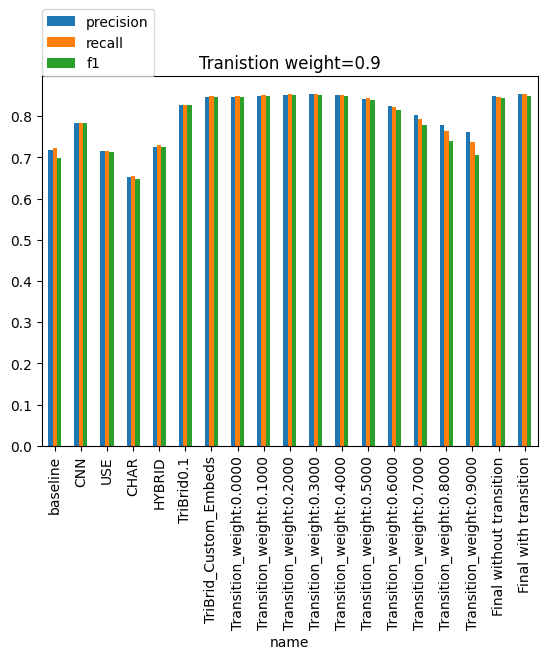

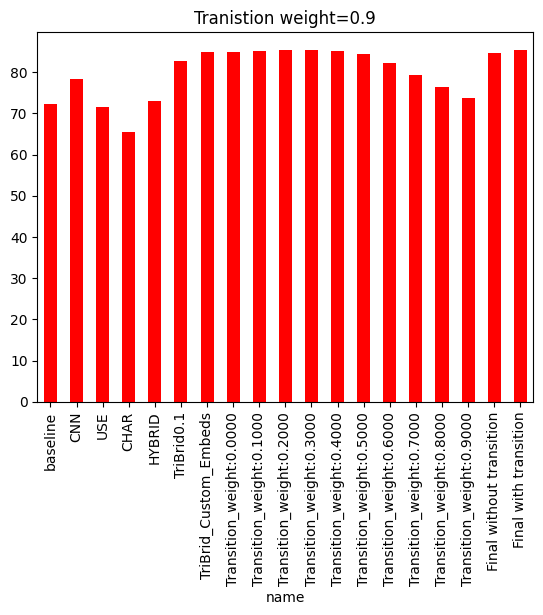

In [384]:
preds = np.argmax(p['outputs'], axis=-1)
_, _, metrics_1 = get_cm_and_final_results(preds, test_label)
MODELS_REPORT = update_report(f'Final without transition', metrics_1)


new = add_matrix(weight=0.3,p=p)
preds = np.argmax(new, axis=-1)
_, _, metrics_2 = get_cm_and_final_results(preds, test_label)
MODELS_REPORT = update_report(f'Final with transition', metrics_2)

MODELS_REPORT[['precision','recall','f1']].plot.bar()
plt.title(f'Tranistion weight={0.1*weight}')
plt.legend(loc=(0,1))
plt.figure()
plt.title(f'Tranistion weight={0.1*weight}')
MODELS_REPORT['accuracy'].plot.bar(color='r')

# Saving and loading model 7

In [386]:
keras.models.save_model(model_7, MODEL_DIR.joinpath('Model.h5'))

/tmp/ipykernel_1073995/3004050538.py:1: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model_7, MODEL_DIR.joinpath('Model.h5'))


: 